### Elección del modelo

El objetivo principal de este proyecto es **predecir si una publicación en Instagram se volverá viral o no**, es decir, resolver un problema de **clasificación binaria** (`sí` / `no`), donde la variable objetivo es la viralidad.

Durante el desarrollo del modelo, se evaluaron varias alternativas de algoritmos de machine learning, entre ellos:
- Regresión logística
- Árboles de decisión simples
- Random Forest

Sin embargo, estos modelos presentaron limitaciones importantes en cuanto a su rendimiento predictivo o calibración de probabilidades. Por ejemplo, algunos modelos eran sensibles al desbalance de clases o no capturaban bien las relaciones no lineales entre las variables.

#### ¿Por qué XGBoost?
Finalmente, el modelo seleccionado fue **XGBoost (Extreme Gradient Boosting)**, calibrado con regresión logística (sigmoid). Además, aplicamos **SMOTE** durante el entrenamiento para balancear las clases, dado que las publicaciones virales eran minoritarias en el dataset. Esto permitió al modelo aprender mejor los patrones asociados a publicaciones de alto rendimiento.

XGBoost calibrado ha sido el modelo que ofreció el **mejor equilibrio entre precisión, interpretabilidad y rendimiento**, cumpliendo con los requisitos tanto técnicos como aplicados del proyecto.


In [1]:
# Librerías generales
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Modelado y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Configuración de pandas
pd.set_option('display.max_columns', None)

In [2]:
# Cargar dataset limpio
df = pd.read_csv("instagram_caption_limpio.csv")
display(df.head())

# Crear variable objetivo binaria (viral si supera el Q3 de engagement)
q75 = df["engagement_ratio"].quantile(0.75)
df["is_viral"] = df["engagement_ratio"] > q75
display(df[["engagement_ratio", "is_viral"]].head())

,account_name,url,caption,caption_length,likes,comments,post_date,day_of_week,hour_of_day,is_night_post,is_special_date,media_type,num_hashtags,num_mentions,num_emojis,has_question,has_call_to_action,followers,followees,engagement_ratio,comment_like_ratio,caption_sentiment,num_exclamations,hashtag_ratio,topic,readability,num_positive_words,num_negative_words,claridad,originalidad,emocion,interaccion,redaccion_viral,valor
0,3inaspain,https://www.instagram.com/3inaspain/reel/DJbtA...,Tus imprescindibles de maquillaje on-the-go ✈️...,243,2354,113,2025-05-09T12:30:00.000Z,Friday,12,False,False,reel,6,0,2,True,False,318000,1377,0.0078,0.0480,neutro,0,0.1622,otro,22.87,1,1,8,6,7,9,6,8
1,3inaspain,https://www.instagram.com/3inaspain/reel/DJZLv...,Estaba deseando enseñarlos 💅🏽\n\n¿Tienes ya nu...,151,506,11,2025-05-08T13:00:00.000Z,Thursday,13,False,False,reel,6,0,4,True,False,318000,1377,0.0016,0.0217,neutro,0,0.3000,promoción,17.45,0,0,8,5,6,7,4,7
2,3inaspain,https://www.instagram.com/3inaspain/reel/DJWnS...,Los Mini Kits te salvan en cualquier momento 💅...,106,396,35,2025-05-07T13:14:31.000Z,Wednesday,13,False,False,reel,6,0,2,False,False,318000,1377,0.0014,0.0884,neutro,0,0.4000,otro,17.38,0,0,8,5,6,7,6,7
3,3inaspain,https://www.instagram.com/3inaspain/reel/DJRkz...,Los mejores compañeros de viaje 🤏🥹\n\n¿Qué más...,127,243,11,2025-05-05T14:07:09.000Z,Monday,14,False,False,reel,5,0,1,True,False,318000,1377,0.0008,0.0453,neutro,0,0.2500,otro,56.70,0,0,8,5,6,7,6,7
4,3inaspain,https://www.instagram.com/3inaspain/reel/DJOxs...,Ellas sí que saben 🔥 y obviamente siempre tie...,104,142,7,2025-05-04T12:00:00.000Z,Sunday,12,False,False,reel,4,0,2,False,False,318000,1377,0.0005,0.0493,neutro,0,0.2500,otro,23.43,0,0,8,5,7,6,6,7


,engagement_ratio,is_viral
0,0.0078,True
1,0.0016,False
2,0.0014,False
3,0.0008,False
4,0.0005,False


In [3]:
# Codificación manual tipo one-hot para hour_of_day
for hour in df['hour_of_day'].unique():
    df[f'hour_of_day_{hour}'] = df['hour_of_day'].apply(lambda x: 1 if x == hour else 0)

# Codificación para day_of_week
for day in df['day_of_week'].unique():
    df[f'day_of_week_{day}'] = df['day_of_week'].apply(lambda x: 1 if x == day else 0)

# Codificación para media_type
for media in df['media_type'].unique():
    df[f'media_type_{media}'] = df['media_type'].apply(lambda x: 1 if x == media else 0)

In [4]:
# Crear columnas faltantes con valor 0 para mantener consistencia
for hour in range(24):
    col = f'hour_of_day_{hour}'
    if col not in df.columns:
        df[col] = 0

In [5]:
# Lista de variables seleccionadas para el modelo
x = [
    "caption_length", "is_night_post", "is_special_date", "num_hashtags", "num_mentions", "num_emojis",
    "has_question", "has_call_to_action", "num_exclamations", "hashtag_ratio", "readability",
    "claridad", "originalidad", "emocion", "interaccion", "redaccion_viral", "valor",
    "hour_of_day_12", "hour_of_day_13", "hour_of_day_14", "hour_of_day_10", "hour_of_day_15",
    "hour_of_day_11", "hour_of_day_16", "hour_of_day_19", "hour_of_day_18", "hour_of_day_17",
    "hour_of_day_9", "hour_of_day_20", "hour_of_day_8", "hour_of_day_7", "hour_of_day_6",
    "hour_of_day_5", "hour_of_day_23", "hour_of_day_0", "hour_of_day_21",
    "day_of_week_Friday", "day_of_week_Thursday", "day_of_week_Wednesday",
    "day_of_week_Monday", "day_of_week_Sunday", "day_of_week_Tuesday", "day_of_week_Saturday",
    "media_type_reel", "media_type_carrusel", "media_type_foto",
    "hour_of_day_1", "hour_of_day_2", "hour_of_day_3", "hour_of_day_4", "hour_of_day_22"
]


# Separar variables predictoras y objetivo
X = df[x]
y = df["is_viral"]

# Guardar columnas seleccionadas para futura predicción
joblib.dump(x, "columnas_modelo.pkl")
joblib.dump(q75, "engagement_q75.pkl")

['engagement_q75.pkl']

In [6]:
# División train/test estratificada (20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear clases en entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar tamaños
print("Tamaño final:", X.shape, y.shape)

Tamaño final: (806, 51) (806,)


In [7]:
# Entrenar modelo XGBoost
xgb_base = XGBClassifier(eval_metric="logloss", random_state=42)

# Calibrar probabilidades con validación cruzada
modelo_calibrado = CalibratedClassifierCV(xgb_base, method='sigmoid', cv=5)
modelo_calibrado.fit(X_train_smote, y_train_smote)

# Guardar modelo entrenado
joblib.dump(modelo_calibrado, "modelo_xgb_calibrado.pkl")
joblib.dump(modelo_calibrado, "modelo_xgb_calibrado.json")

['modelo_xgb_calibrado.json']

📋 Classification Report - XGBoost (umbral 0.4):
              precision    recall  f1-score   support

       False       0.96      0.93      0.95       121
        True       0.82      0.88      0.85        41

    accuracy                           0.92       162
   macro avg       0.89      0.91      0.90       162
weighted avg       0.92      0.92      0.92       162



['umbral_prediccion.pkl']

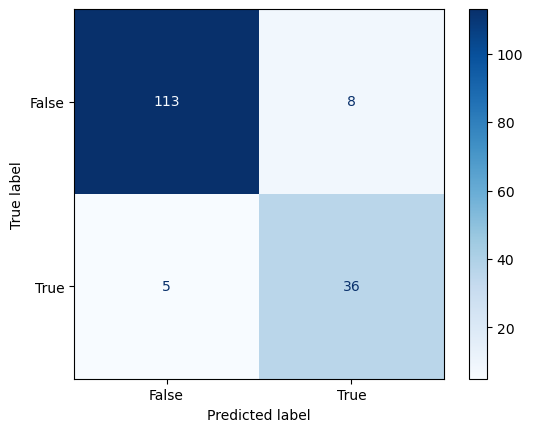

In [8]:
# Predicciones con umbral ajustado
y_proba = modelo_calibrado.predict_proba(X_test)[:, 1]
umbral = 0.4
y_pred = (y_proba >= umbral).astype(int)

# Evaluación
print("📋 Classification Report - XGBoost (umbral 0.4):")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

# Guardar umbral
joblib.dump(umbral, "umbral_prediccion.pkl")

El modelo XGBoost calibrado con regresión logística fue evaluado sobre el conjunto de test (20% del total), utilizando un **umbral ajustado de 0.4** para la clasificación de publicaciones como virales.

### Métricas Clave:

- **Accuracy general: 92%**
  - Esto indica que el modelo acierta en 92 de cada 100 predicciones.
  
- **Precision (clase True / viral): 82%**
  - De todas las publicaciones que el modelo predijo como virales, el 82% realmente lo eran. Esto es útil para evitar falsos positivos.

- **Recall (clase True / viral): 88%**
  - De todas las publicaciones realmente virales, el modelo identificó correctamente el 88%. Es una métrica crítica cuando no queremos dejar escapar potenciales publicaciones exitosas.

- **F1-score (clase True): 85%**
  - Balance entre precisión y recall. Este valor muestra que el modelo tiene un buen compromiso entre detectar virales y no etiquetar como viral lo que no lo es.

### Conclusión:

Este rendimiento respalda la elección de XGBoost con calibración de probabilidades. El modelo ofrece:
- Alta capacidad predictiva.
- Buen balance entre precisión y sensibilidad.
- Adecuada generalización a datos nuevos, gracias a la validación cruzada y calibración.

Además, el umbral de 0.4 fue estratégicamente elegido para **priorizar recall**, ya que en este contexto es más valioso detectar un posible post viral que perderlo por ser demasiado conservadores.

               Variable  Importancia
3          num_hashtags     0.173394
45      media_type_foto     0.071329
16                valor     0.063902
28       hour_of_day_20     0.048997
30        hour_of_day_7     0.045517
43      media_type_reel     0.045200
11             claridad     0.043139
24       hour_of_day_19     0.042685
44  media_type_carrusel     0.042542
21       hour_of_day_15     0.042053
18       hour_of_day_13     0.033873
25       hour_of_day_18     0.032378
12         originalidad     0.029522
17       hour_of_day_12     0.026963
22       hour_of_day_11     0.026550
4          num_mentions     0.026239
6          has_question     0.022915
9         hashtag_ratio     0.020868
40   day_of_week_Sunday     0.019046
20       hour_of_day_10     0.018121


/var/folders/gs/26000r592n9fn9v0kpbm0z5m0000gp/T/ipykernel_15503/3892858051.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia.head(20), x='Importancia', y='Variable', palette='viridis')


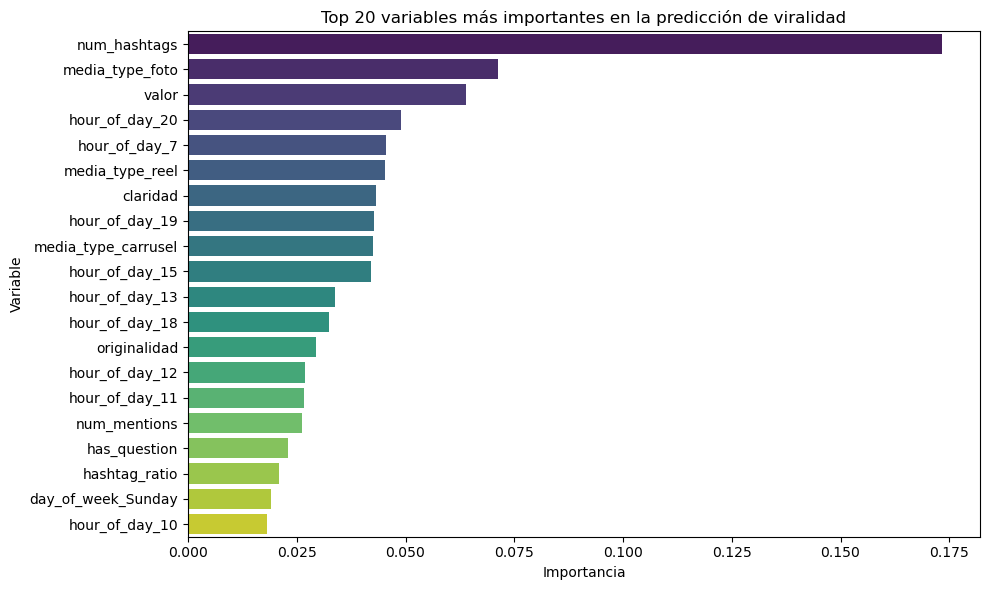

In [9]:
# Cargar modelo y columnas
modelo_calibrado = joblib.load("modelo_xgb_calibrado.pkl")
columnas = joblib.load("columnas_modelo.pkl")

# Extraer el modelo base desde la calibración
modelo_base = modelo_calibrado.calibrated_classifiers_[0].estimator

# Obtener importancias de variables
importancias = modelo_base.feature_importances_

# Crear DataFrame ordenado
df_importancia = pd.DataFrame({
    'Variable': columnas,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar top 20
print(df_importancia.head(20))

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancia.head(20), x='Importancia', y='Variable', palette='viridis')
plt.title("Top 20 variables más importantes en la predicción de viralidad")
plt.tight_layout()
plt.show()


El gráfico muestra las 20 variables con mayor importancia en el modelo XGBoost, medida por su contribución a reducir el error durante el entrenamiento.

### Principales hallazgos:

- **`num_hashtags`** es, con diferencia, la variable más influyente. Esto indica que el número de hashtags en un caption tiene un fuerte impacto en la probabilidad de que la publicación sea viral. 

- **`media_type_foto`**, **`media_type_reel`** y **`media_type_carrusel`** también aparecen como importantes, lo que evidencia que el tipo de contenido publicado tiene un peso significativo en la viralidad. Especialmente, las **fotos** parecen asociarse fuertemente a viralidad en este dataset.

- Variables relacionadas con la **hora de publicación** como `hour_of_day_20`, `hour_of_day_7`, `hour_of_day_19`, etc., muestran que **el momento del día** también afecta fuertemente la probabilidad de viralidad.

- Las dimensiones semánticas del caption como **`valor`**, **`claridad`** y **`originalidad`** también destacan entre las más importantes. Esto demuestra que no solo importa el cuándo y cómo, sino también **el contenido emocional y cognitivo del texto**.

- Variables adicionales como **`num_mentions`**, **`has_question`** y **`hashtag_ratio`** también aportan información relevante, indicando que la interacción directa con la audiencia (menciones, preguntas) y la densidad de hashtags son elementos a tener en cuenta.

/Users/elena/Desktop/miniconda3/envs/proyecto_final/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


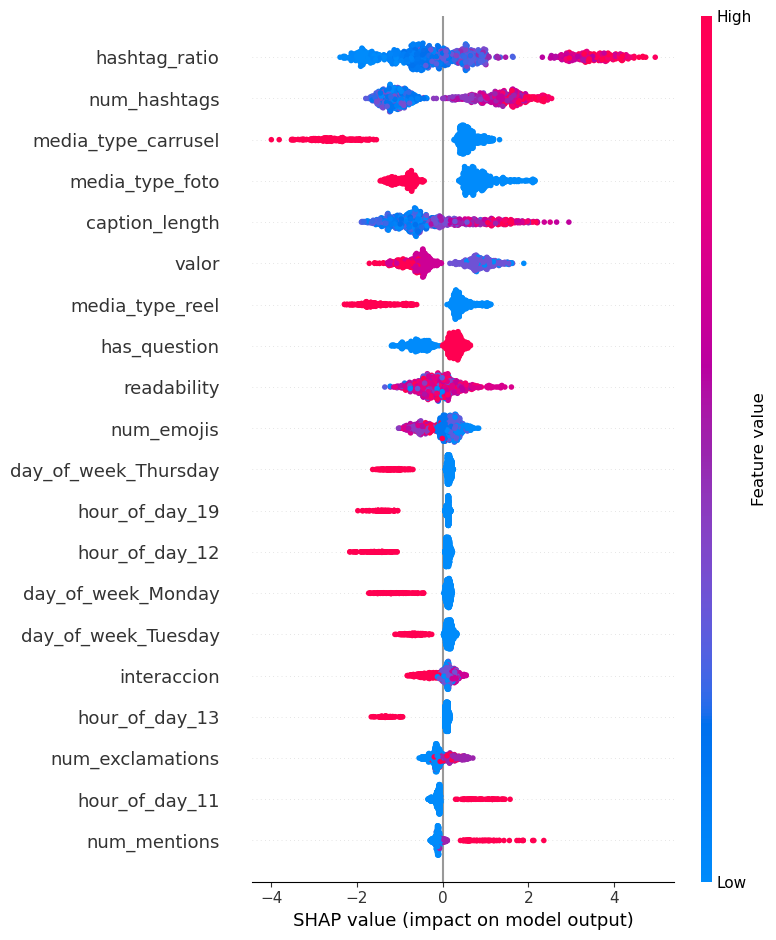

In [11]:
import shap
explainer = shap.Explainer(modelo_base)
shap_values = explainer(X_train_smote)
shap.summary_plot(shap_values, X_train_smote)

Además del análisis de importancia, utilizamos **valores SHAP** para entender no solo *cuánto* contribuye una variable, sino *cómo* lo hace: si incrementa o disminuye la probabilidad de que un post sea viral.

El gráfico SHAP muestra:

- **El eje X** representa el impacto de cada valor de la variable sobre la predicción de viralidad (positivo ➜ aumenta la probabilidad de ser viral, negativo ➜ la reduce).
- **Los colores** indican si el valor de la variable es alto (rojo) o bajo (azul).

### Hallazgos clave:

- **`hashtag_ratio` y `num_hashtags`**: valores altos (en rojo) empujan claramente la predicción hacia la viralidad. Un uso intensivo de hashtags está positivamente asociado con el éxito del post.

- **`media_type_carrusel`**: tiene un fuerte impacto negativo cuando está activo (valor 1 en rojo), indicando que los carruseles suelen ser menos virales en este dataset.

- **`caption_length`**: los captions más largos tienden a mejorar la viralidad, probablemente porque permiten desarrollar más contenido emocional, informativo o interactivo.

- **`num_emojis`**: tienen un efecto más neutro, podemos utilizarlos para poteciar la viralidad del post, pero sin pasarnos.

- **Variables temporales** (`hour_of_day_19`, `hour_of_day_11`, etc.): muestran impactos mixtos. Por ejemplo, `hour_of_day_19` con valor alto puede reducir la probabilidad de viralidad, a pesar de su alta frecuencia de uso. Lo mismo pasa para las 12:00, sin embargo, a las 11:00 sucede al revés.
